# Title: ***Initial Data Processing: Missing Data, Outliers and Fractional Diff***
## Group Member<br>

Felipe Carvalho Ueta,  7210491<br>
Felipe Rubim,      8105710<br>

In [1]:
# Import required packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math

In [2]:
import sys
sys.path.append('../')

import os
from IPython.display import display, Math, Latex
from src.finance_ml.outliers.outliers import DataOutliers
from src.finance_ml.data_preparation.data_preparation import DataLoader
from src.finance_ml.Outlier_Detection_using_Isolation_forest.isolation_forest import OutlierDetector, load_and_prepare_data


In [3]:
gld = '../data/commodities/GLD_2020-04-07_2022-04-06.parquet'
pdbc = '../data/commodities/PDBC_2020-04-07_2022-04-06.parquet'
slv = '../data/commodities/SLV_2020-04-07_2022-04-06.parquet'

In [4]:
dataloader = DataLoader(time_index_col='DATE',
                        keep_cols=['VOLUME', 'OPEN', 'HIGHT', 'LOW', 'CLOSE', 'VW', 'TRANSACTIONS'])

In [5]:
df = load_and_prepare_data(gld, dataloader, 'GLD',150000)
df = df.sort_index()

In [6]:
df.head()

,GLD_VOLUME,GLD_OPEN,GLD_HIGHT,GLD_LOW,GLD_CLOSE,GLD_VW,GLD_TRANSACTIONS
DATE,,,,,,,
2020-04-07 15:43:00,21071.0,155.880,155.94,155.860,155.926,155.9052,152.0
2020-04-07 15:44:00,23010.0,155.930,155.97,155.900,155.900,155.9342,165.0
2020-04-07 15:45:00,31544.0,155.920,155.94,155.720,155.735,155.8012,292.0
2020-04-07 15:46:00,42645.0,155.760,155.84,155.760,155.840,155.7910,153.0
2020-04-07 15:47:00,3735.0,155.805,155.82,155.795,155.810,155.8070,47.0


### Remove duplicated Values

In [8]:
df = df[~df.index.duplicated()]

In [9]:
df['YearMonthDay'] = [dt.date().isoformat() for dt in df.index]
df['YearMonth'] = [f"{dt.year}-{dt.month:02d}" for dt in df.index]

In [10]:
df['Week'] = [np.where(dt.date().day<=7,'s1',
                       np.where(dt.date().day<=14,'s2',
                                np.where(dt.date().day<=21,'s3',
                                         's4'))) for dt in df.index]

### Missing Data

In [12]:
df.isnull().sum()

GLD_VOLUME          0
GLD_OPEN            0
GLD_HIGHT           0
GLD_LOW             0
GLD_CLOSE           0
GLD_VW              4
GLD_TRANSACTIONS    4
YearMonthDay        0
YearMonth           0
Week                0
dtype: int64

In [13]:
df = df[~df['GLD_VW'].isna()]
df.isnull().sum()

GLD_VOLUME          0
GLD_OPEN            0
GLD_HIGHT           0
GLD_LOW             0
GLD_CLOSE           0
GLD_VW              0
GLD_TRANSACTIONS    0
YearMonthDay        0
YearMonth           0
Week                0
dtype: int64

### Graphics

<Axes: xlabel='YearMonthDay'>

<Figure size 640x480 with 0 Axes>

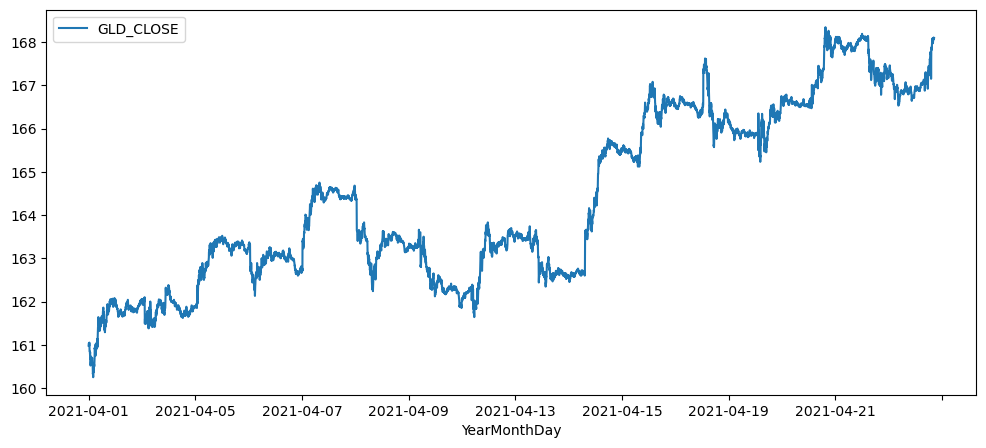

In [15]:
plt.figure() 
df.loc[df['YearMonth']=='2021-04',['YearMonthDay', 'GLD_CLOSE']].plot(x='YearMonthDay',figsize=(12, 5))

### Outliers

In [17]:
from sklearn.ensemble import IsolationForest

In [18]:
isolation_forest = IsolationForest(n_estimators=100)

In [19]:
start_date = df.index.min()
end_date = df.index.max()


date_ranges = pd.date_range(start=start_date, end=end_date, freq='7D')

In [20]:
df_ = pd.DataFrame(columns=df.columns)

for start in date_ranges:
    end = start + pd.Timedelta(days=7)
    mask = (df.index >= start) & (df.index < end)
    interval_df = df.loc[mask]
    isolation_forest = IsolationForest(n_estimators=100)
    anomalies = isolation_forest.fit_predict(interval_df.loc[:, ~interval_df.columns.isin(['YearMonthDay', 'YearMonth', 'Week'])])
    #interval_df['anomaly'] = anomalies
    df_ = pd.concat([df_, interval_df[anomalies==1]])

C:\Users\felip\AppData\Local\Temp\ipykernel_4768\2898298932.py:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_ = pd.concat([df_, interval_df[anomalies==1]])
C:\Users\felip\AppData\Local\Temp\ipykernel_4768\2898298932.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ = pd.concat([df_, interval_df[anomalies==1]])


<Axes: xlabel='YearMonthDay'>

<Figure size 640x480 with 0 Axes>

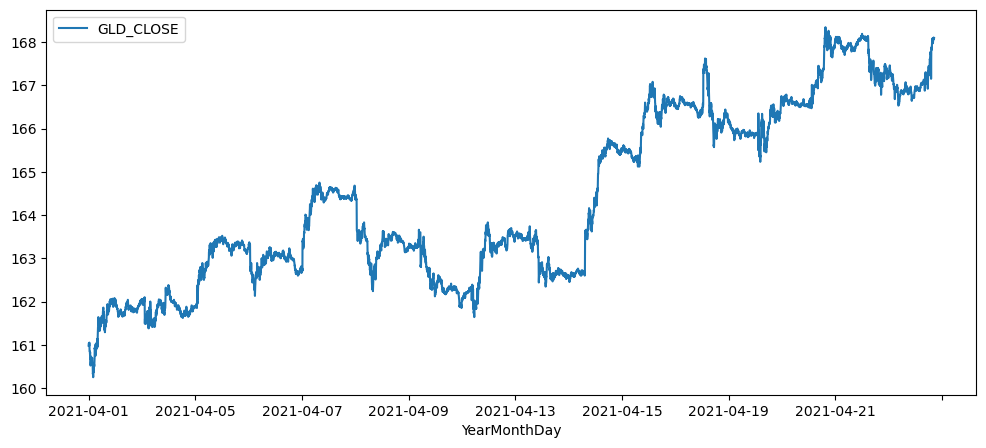

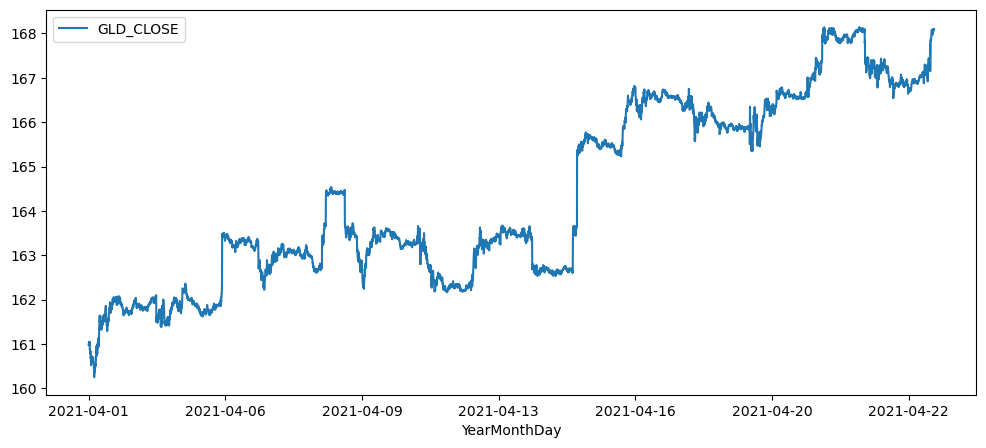

In [21]:
plt.figure() 

df.loc[df['YearMonth']=='2021-04',['YearMonthDay', 'GLD_CLOSE']].plot(x='YearMonthDay', figsize=(12, 5))
df_.loc[df_['YearMonth']=='2021-04',['YearMonthDay', 'GLD_CLOSE']].plot(x= 'YearMonthDay', figsize=(12, 5))

In [22]:
#pip install TA-Lib

In [23]:
import talib as ta

In [24]:
# Obtém os grupos de funções
for group, funcs in ta.get_function_groups().items():
    print(group)
    print('-----------------------------------------')
    for func in funcs:
        # A descrição pode ser obtida assim
        print(func)  # Se não tiver info, apenas exibe o nome da função
    print()


Cycle Indicators
-----------------------------------------
HT_DCPERIOD
HT_DCPHASE
HT_PHASOR
HT_SINE
HT_TRENDMODE

Math Operators
-----------------------------------------
ADD
DIV
MAX
MAXINDEX
MIN
MININDEX
MINMAX
MINMAXINDEX
MULT
SUB
SUM

Math Transform
-----------------------------------------
ACOS
ASIN
ATAN
CEIL
COS
COSH
EXP
FLOOR
LN
LOG10
SIN
SINH
SQRT
TAN
TANH

Momentum Indicators
-----------------------------------------
ADX
ADXR
APO
AROON
AROONOSC
BOP
CCI
CMO
DX
MACD
MACDEXT
MACDFIX
MFI
MINUS_DI
MINUS_DM
MOM
PLUS_DI
PLUS_DM
PPO
ROC
ROCP
ROCR
ROCR100
RSI
STOCH
STOCHF
STOCHRSI
TRIX
ULTOSC
WILLR

Overlap Studies
-----------------------------------------
BBANDS
DEMA
EMA
HT_TRENDLINE
KAMA
MA
MAMA
MAVP
MIDPOINT
MIDPRICE
SAR
SAREXT
SMA
T3
TEMA
TRIMA
WMA

Pattern Recognition
-----------------------------------------
CDL2CROWS
CDL3BLACKCROWS
CDL3INSIDE
CDL3LINESTRIKE
CDL3OUTSIDE
CDL3STARSINSOUTH
CDL3WHITESOLDIERS
CDLABANDONEDBABY
CDLADVANCEBLOCK
CDLBELTHOLD
CDLBREAKAWAY
CDLCLOSINGMARUBOZU


In [26]:
high=df_['GLD_HIGHT']
low=df_['GLD_LOW']
open=df_['GLD_OPEN']
close=df_['GLD_CLOSE']
volume=df_['GLD_VOLUME']
period = 14

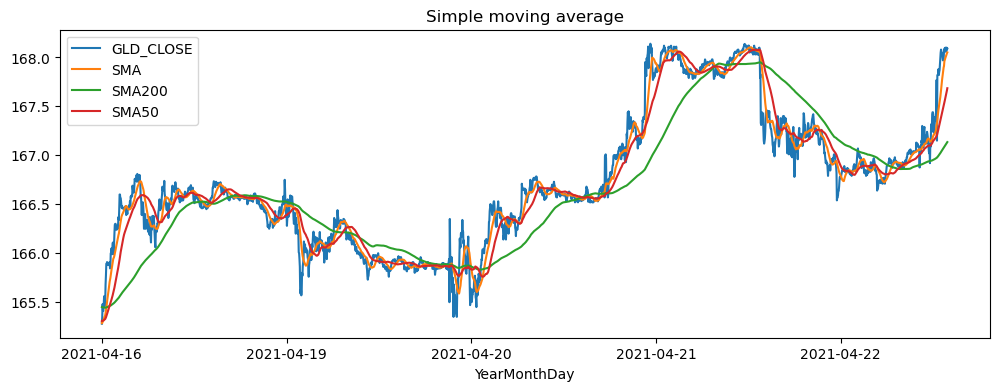

In [28]:
df_['SMA'] = ta.SMA(close,20)
df_['SMA200'] = ta.SMA(close,200)
df_['SMA50'] = ta.SMA(close,50)
df_.loc[df_['YearMonthDay']>'2021-04-15',['YearMonthDay', 'GLD_CLOSE','SMA','SMA200', 'SMA50']].plot(x='YearMonthDay', figsize=(12,4))
plt.title("Simple moving average")
plt.show()

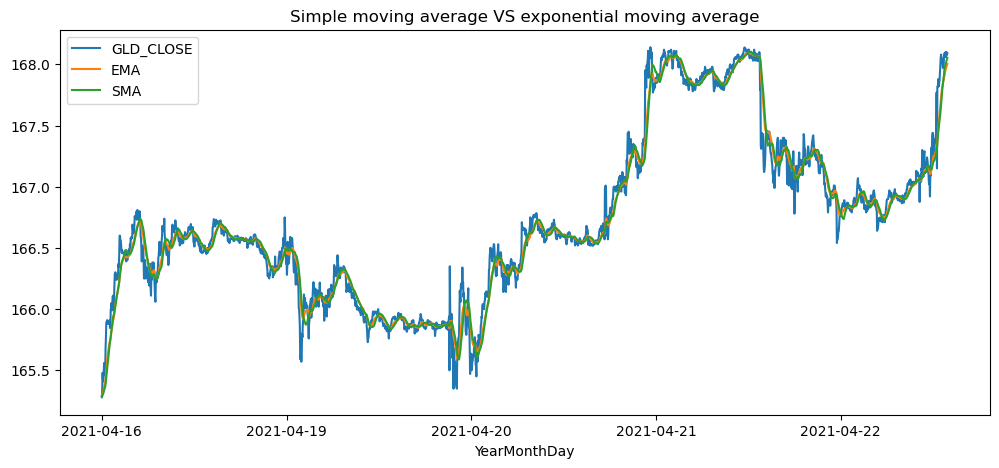

In [29]:
df_['SMA'] = ta.SMA(close, timeperiod = 20)
df_['EMA'] = ta.EMA(close, timeperiod = 20)
df_.loc[df_['YearMonthDay']>'2021-04-15',['YearMonthDay', 'GLD_CLOSE','EMA','SMA']].plot(x='YearMonthDay', figsize=(12,5))
plt.title("Simple moving average VS exponential moving average")
plt.show()

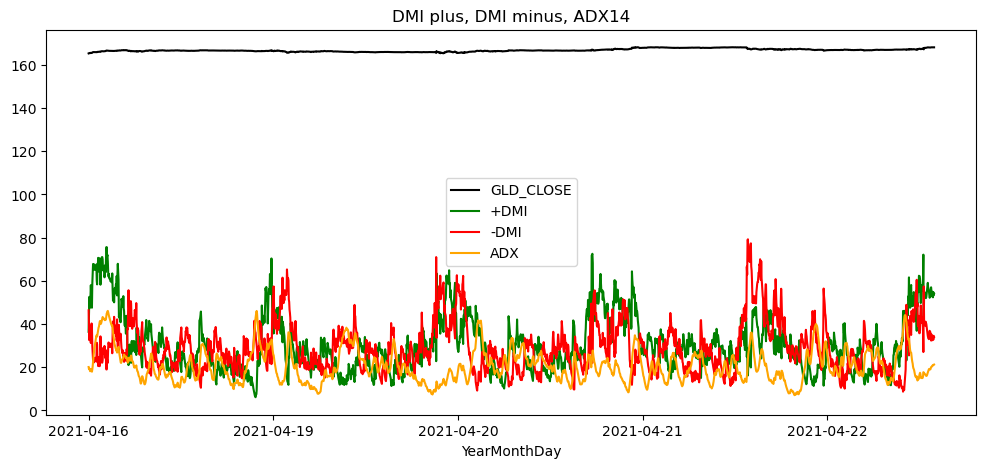

In [31]:
df_['+DMI'] = ta.PLUS_DI(high, low, close, timeperiod=14)
df_['-DMI'] = ta.MINUS_DI(high, low, close, timeperiod=14)
df_['ADX'] = ta.ADX(high, low, close, timeperiod=14)
df_.loc[df_['YearMonthDay']>'2021-04-15',['YearMonthDay','GLD_CLOSE','+DMI','-DMI','ADX']].plot(x='YearMonthDay',figsize=(12,5), color=['black','green','red','orange'])
plt.title("DMI plus, DMI minus, ADX14")
plt.show()

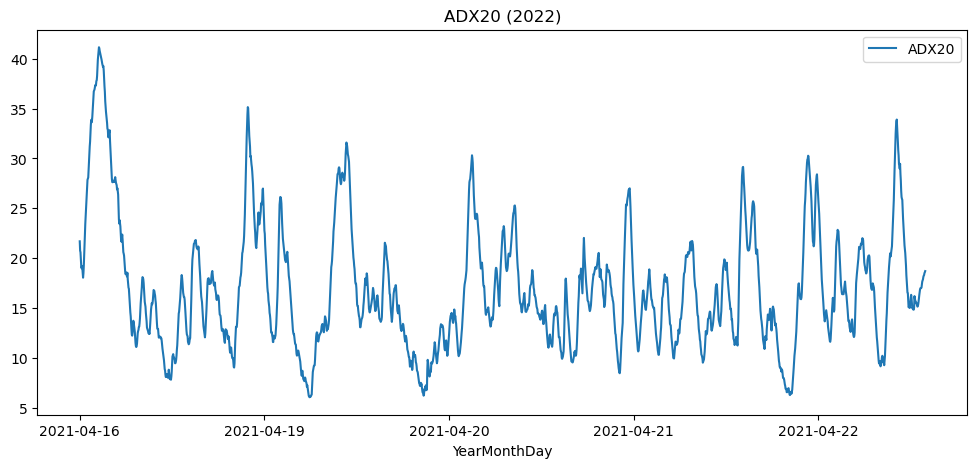

In [33]:
df_['ADX20'] = ta.ADX(high, low, close, timeperiod=20)
df_.loc[df_['YearMonthDay']>'2021-04-15',['YearMonthDay' ,'ADX20']].plot(x='YearMonthDay',figsize=(12,5))
plt.title("ADX20 (2022)")
plt.show()

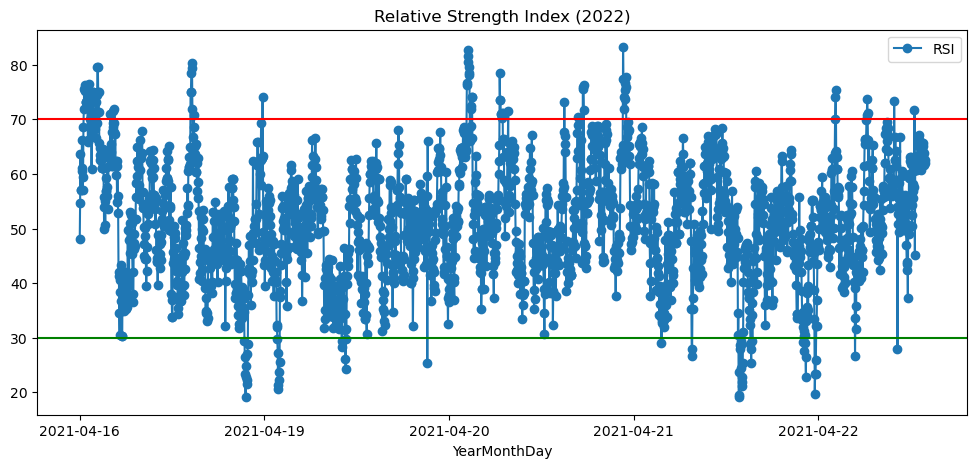

In [34]:
df_['RSI'] = ta.RSI(close,14)
df_.loc[df_['YearMonthDay']>'2021-04-15',['YearMonthDay' ,'RSI']].plot(x='YearMonthDay',figsize=(12,5), marker ='o')
plt.title("Relative Strength Index (2022)")
plt.axhline(y=30, color='green', linestyle='-')
plt.axhline(y=70, color='red', linestyle='-')
x = np.arange(0, len(df_['RSI']),0.1)

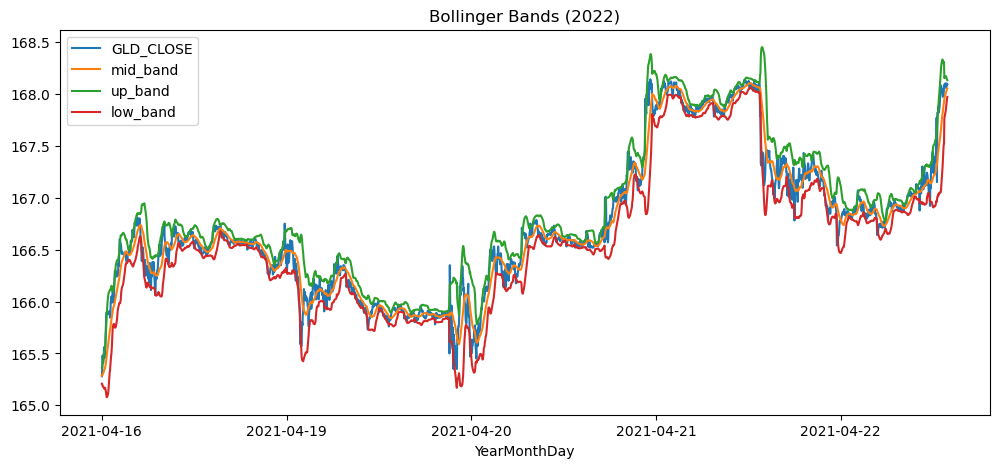

In [36]:
df_['up_band'], df_['mid_band'], df_['low_band'] = ta.BBANDS(close, timeperiod =20)
df_.loc[df_['YearMonthDay']>'2021-04-15',['YearMonthDay', 'GLD_CLOSE','mid_band','up_band','low_band']].plot(x='YearMonthDay',figsize=(12,5))
plt.title("Bollinger Bands (2022)")
plt.show()

In [38]:
df_.tail()

,GLD_VOLUME,GLD_OPEN,GLD_HIGHT,GLD_LOW,GLD_CLOSE,GLD_VW,GLD_TRANSACTIONS,YearMonthDay,YearMonth,Week,...,SMA50,EMA,+DMI,-DMI,ADX,ADX20,RSI,up_band,mid_band,low_band
2021-04-23 12:42:00,300.0,168.07,168.07,168.07,168.07,168.0700,2.0,2021-04-23,2021-04,s4,...,167.608596,167.964365,53.019786,33.674726,20.785637,18.232853,62.522406,168.170282,168.00799,167.845698
2021-04-23 12:46:00,123.0,168.06,168.06,168.06,168.06,168.0654,4.0,2021-04-23,2021-04,s4,...,167.625996,167.973473,52.363915,34.495190,20.770383,18.298184,61.634143,168.158682,168.01999,167.881298
2021-04-23 12:47:00,253.0,168.10,168.10,168.10,168.10,168.0957,7.0,2021-04-23,2021-04,s4,...,167.644796,167.985523,54.773899,32.750024,21.084160,18.499417,63.846719,168.151282,168.03249,167.913698
2021-04-23 12:48:00,2014.0,168.08,168.08,168.08,168.08,168.0799,8.0,2021-04-23,2021-04,s4,...,167.664396,167.994521,53.321340,34.533439,21.105661,18.581224,61.923780,168.137019,168.04299,167.948961
2021-04-23 12:50:00,498.0,168.09,168.09,168.09,168.09,168.0900,4.0,2021-04-23,2021-04,s4,...,167.685396,168.003614,53.978507,34.047259,21.215437,18.696172,62.531424,168.131452,168.05099,167.970528
